In [7]:
import numpy as np
import time

third=[]
for i in range(10):
  T = 1024
  N=T*(i+1)
  A_cpu = np.random.rand(N, N).astype(np.float32)
  B_cpu = np.random.rand(N, N).astype(np.float32)

  start = time.time()
  C_cpu = np.matmul(A_cpu, B_cpu)
  end = time.time()
  third.append(end-start)
  print(f"Mnożenie macierzy na CPU trwało: {end - start:.5f} sekund.")


Mnożenie macierzy na CPU trwało: 0.02790 sekund.
Mnożenie macierzy na CPU trwało: 0.20431 sekund.
Mnożenie macierzy na CPU trwało: 0.68142 sekund.
Mnożenie macierzy na CPU trwało: 1.59540 sekund.
Mnożenie macierzy na CPU trwało: 3.82575 sekund.
Mnożenie macierzy na CPU trwało: 7.73173 sekund.
Mnożenie macierzy na CPU trwało: 10.82322 sekund.
Mnożenie macierzy na CPU trwało: 13.87409 sekund.
Mnożenie macierzy na CPU trwało: 20.17430 sekund.
Mnożenie macierzy na CPU trwało: 27.17612 sekund.


In [1]:
import cupy as cp
import time
import numpy as np
first=[]
for i in range(10):
  T = 1024
  N=T*(i+1)
  A_cpu = np.random.rand(N, N).astype(np.float32)
  B_cpu = np.random.rand(N, N).astype(np.float32)
  A_gpu = cp.array(A_cpu)
  B_gpu = cp.array(B_cpu)

  start = time.time()
  C_gpu = cp.matmul(A_gpu, B_gpu)
  cp.cuda.Stream.null.synchronize()  # Synchronizacja z GPU
  end = time.time()
  first.append(end-start)
  print(f"Mnożenie macierzy na GPU dla rozmiaru: {N} trwało: {end - start:.5f} sekund.")
del A_gpu, B_gpu, C_gpu

Mnożenie macierzy na GPU dla rozmiaru: 1024 trwało: 0.09251 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 2048 trwało: 0.01085 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 3072 trwało: 0.02379 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 4096 trwało: 0.05442 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 5120 trwało: 0.10011 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 6144 trwało: 0.16638 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 7168 trwało: 0.23136 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 8192 trwało: 0.31720 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 9216 trwało: 0.48098 sekund.
Mnożenie macierzy na GPU dla rozmiaru: 10240 trwało: 0.61276 sekund.


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda


In [3]:
kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0;
    if (row < N && col < N) {
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""



In [4]:
#GPU z CUDA

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")
second=[]
for i in range(10):
  T = 1024
  N=T*(i+1)
  C_cpu = np.empty((N, N), np.float32)
  A_gpu = cuda.mem_alloc(A_cpu.nbytes)
  B_gpu = cuda.mem_alloc(B_cpu.nbytes)
  C_gpu = cuda.mem_alloc(C_cpu.nbytes)

  cuda.memcpy_htod(A_gpu, A_cpu)
  cuda.memcpy_htod(B_gpu, B_cpu)
  block_size = (32, 32, 1)

  grid_size = (int(N/32), int(N/32), 1)

  start = time.time()
  matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)

  cuda.Context.synchronize()
  cuda.memcpy_dtoh(C_cpu, C_gpu)
  end = time.time()
  second.append(end-start)
  print(f"Mnożenie macierzy na dla rozmiaru: {end-start} GPU trwało: {end - start:.5f} sekund.")
  del A_gpu, B_gpu, C_gpu

Mnożenie macierzy na dla rozmiaru: 0.011137723922729492 GPU trwało: 0.01114 sekund.
Mnożenie macierzy na dla rozmiaru: 0.050847768783569336 GPU trwało: 0.05085 sekund.
Mnożenie macierzy na dla rozmiaru: 0.1199641227722168 GPU trwało: 0.11996 sekund.
Mnożenie macierzy na dla rozmiaru: 0.26888370513916016 GPU trwało: 0.26888 sekund.
Mnożenie macierzy na dla rozmiaru: 0.5205686092376709 GPU trwało: 0.52057 sekund.
Mnożenie macierzy na dla rozmiaru: 0.8978817462921143 GPU trwało: 0.89788 sekund.
Mnożenie macierzy na dla rozmiaru: 1.5127203464508057 GPU trwało: 1.51272 sekund.
Mnożenie macierzy na dla rozmiaru: 2.2339422702789307 GPU trwało: 2.23394 sekund.
Mnożenie macierzy na dla rozmiaru: 3.0650129318237305 GPU trwało: 3.06501 sekund.
Mnożenie macierzy na dla rozmiaru: 4.2779271602630615 GPU trwało: 4.27793 sekund.


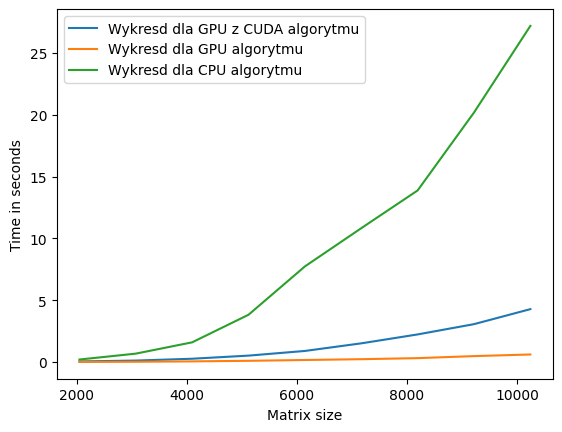

In [10]:
import matplotlib.pyplot as plt
#x = [first[i] for i in range(1, 10)]
x = [T*(i+1) for i in range(1, 10)]
y = [second[i] for i in range(1, 10)]
y2 = [first[i] for i in range(1, 10)]
y3 = [third[i] for i in range(1,10)]
plt.plot(x, y, label="Wykres dla GPU z CUDA algorytmu")
plt.plot(x, y2, label="Wykres dla GPU algorytmu")
plt.plot(x, y3, label="Wykres dla CPU algorytmu")
plt.legend()
plt.xlabel("Matrix size")
plt.ylabel("Time in seconds")
plt.show()
